# Introduction
This notebook's purpose is to show ROC(receiver operating characteristic) curve for each of our models.

## Prepare environment

In [1]:
import os
os.chdir(r"../..")

import numpy as np
import torch
import pandas as pd

from typing import Type
from matplotlib import pyplot as plt
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.metrics import roc_curve, auc

from dataset.dataset_type import DatasetType
from dataset.dataset_info import DatasetInfo, MMClassifierDatasetInfo
from files_handler.model_files_handler import ModelFilesHandler
device = "cuda" if torch.cuda.is_available() else "cpu"

## Prepare dataset class

In [2]:
class STARCOPDataset(Dataset):
    def __init__(
            self,
            data_path: str,
            data_type: DatasetType,
            image_info_class: Type[DatasetInfo],
            crop_size: int = 1,
    ):
        self.images_path = os.path.join(data_path, data_type.get_folder_name(), data_type.get_folder_name())
        self.image_info = image_info_class
        self.csv = pd.read_csv(os.path.join(data_path, data_type.value + ".csv"))
        self.crop_size = crop_size

    def __len__(self):
        return len(self.csv) * (self.crop_size * self.crop_size)

    def __getitem__(self, index):
        return self._get_raw_item(index)

    def _get_raw_item(self, index):
        file_index = index // (self.crop_size * self.crop_size)
        images_directory_path = os.path.join(self.images_path, self.csv["id"][file_index])

        return self.image_info.load_tensor(
            images_directory_path,
            grid_id=index % (self.crop_size * self.crop_size),
            crop_size=self.crop_size
        )

## Create dataloaders

In [3]:
dataset = STARCOPDataset(
    data_path=r"data",
    data_type=DatasetType.TEST,
    image_info_class=MMClassifierDatasetInfo,
)

dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
model_handler = ModelFilesHandler()

## Compute probabilities for CNN

In [4]:
file_name = r"best_models\CNN\model_cnn_2024_12_14_13_20_07.pickle"
cnn_model, _, _, _ = model_handler.load_model(file_name=file_name)

cnn_model.eval()
cnn_model.to(device)

cnn_probabilities = []
all_labels = []
for id, image in enumerate(dataloader):
    (tensor_AVIRIS, tensor_mag1c, filtered_image, label) = image
    input_image = torch.cat((tensor_AVIRIS, tensor_mag1c), dim=1).to(device)
    labels = label.long().to(device)

    outputs = cnn_model(input_image)
    processed_outputs = torch.softmax(outputs, dim=1).cpu().detach().numpy()
    cnn_probabilities.extend(processed_outputs[:, 1].tolist())
    all_labels.extend(label.numpy().tolist())

cnn_model = cnn_model.to("cpu")

## Compute probabilities for DETR

In [5]:
file_name = r"best_models\DETR\model_detr_2024_12_15_11_35_17.pickle"
detr_model, _, _, _ = model_handler.load_model(file_name=file_name)

detr_model.eval()
detr_model.to(device)

detr_probabilities = []
for id, image in enumerate(dataloader):
    (tensor_AVIRIS, tensor_mag1c, filtered_image, label) = image
    input_image = torch.cat((tensor_AVIRIS, tensor_mag1c), dim=1).to(device)
    labels = label.long().to(device)

    outputs = detr_model(input_image)
    processed_outputs = torch.softmax(outputs, dim=1).cpu().detach().numpy()
    detr_probabilities.extend(processed_outputs[:, 1].tolist())

detr_model = detr_model.to("cpu")

D:\Projects\studia\polsl_ssi_1\MethaneDetection\Thesis\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Compute probabilities for Methane Mapper

In [6]:
file_name = r"best_models\MethaneMapper\model_transformer_classifier_2024_12_02_00_37_54.pickle"
mm_model, _, _, _ = model_handler.load_model(file_name=file_name)

mm_model.eval()
mm_model.to(device)

mm_probabilities = []
for id, image in enumerate(dataloader):
    (tensor_AVIRIS, tensor_mag1c, filtered_image, label) = image
    input_image = torch.cat((tensor_AVIRIS, tensor_mag1c), dim=1).to(device)
    filtered_image = filtered_image.to(device)
    labels = label.long().to(device)

    outputs = mm_model(input_image, filtered_image)
    processed_outputs = torch.softmax(outputs, dim=1).cpu().detach().numpy()
    mm_probabilities.extend(processed_outputs[:, 1].tolist())

mm_model = mm_model.to("cpu")

## Compute probabilities for ViT

In [7]:
file_name = r"best_models\VIT\model_vit_2024_12_15_11_50_56.pickle"
vit_model, _, _, _ = model_handler.load_model(file_name=file_name)

vit_model.eval()
vit_model.to(device)

vit_probabilities = []
for id, image in enumerate(dataloader):
    (tensor_AVIRIS, tensor_mag1c, filtered_image, label) = image
    input_image = torch.cat((tensor_AVIRIS, tensor_mag1c), dim=1).to(device)
    labels = label.long().to(device)

    outputs = vit_model(input_image)
    processed_outputs = torch.softmax(outputs, dim=1).cpu().detach().numpy()
    vit_probabilities.extend(processed_outputs[:, 1].tolist())

vit_model = vit_model.to("cpu")

## Function for plotting ROC curve


In [8]:
def show_roc_curve(labels, probabilities, filename):
    fpr, tpr, thresholds = roc_curve(labels, probabilities)
    roc_auc = auc(fpr, tpr)

    plt.rcParams["font.size"] = 40
    plt.rcParams["font.family"] = 'Times New Roman'
    plt.figure(figsize=(16, 12))

    plt.plot(fpr, tpr, color='orange', lw=3, label=f"ROC curve (AUC = {roc_auc:.3f})")
    plt.plot([0, 1], [0, 1], color='blue', lw=1, linestyle='--', label="Random guess")

    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.savefig(filename)
    plt.show()

## Restore environment

In [9]:
os.chdir(r".\notebooks\experiments")

## CNN ROC

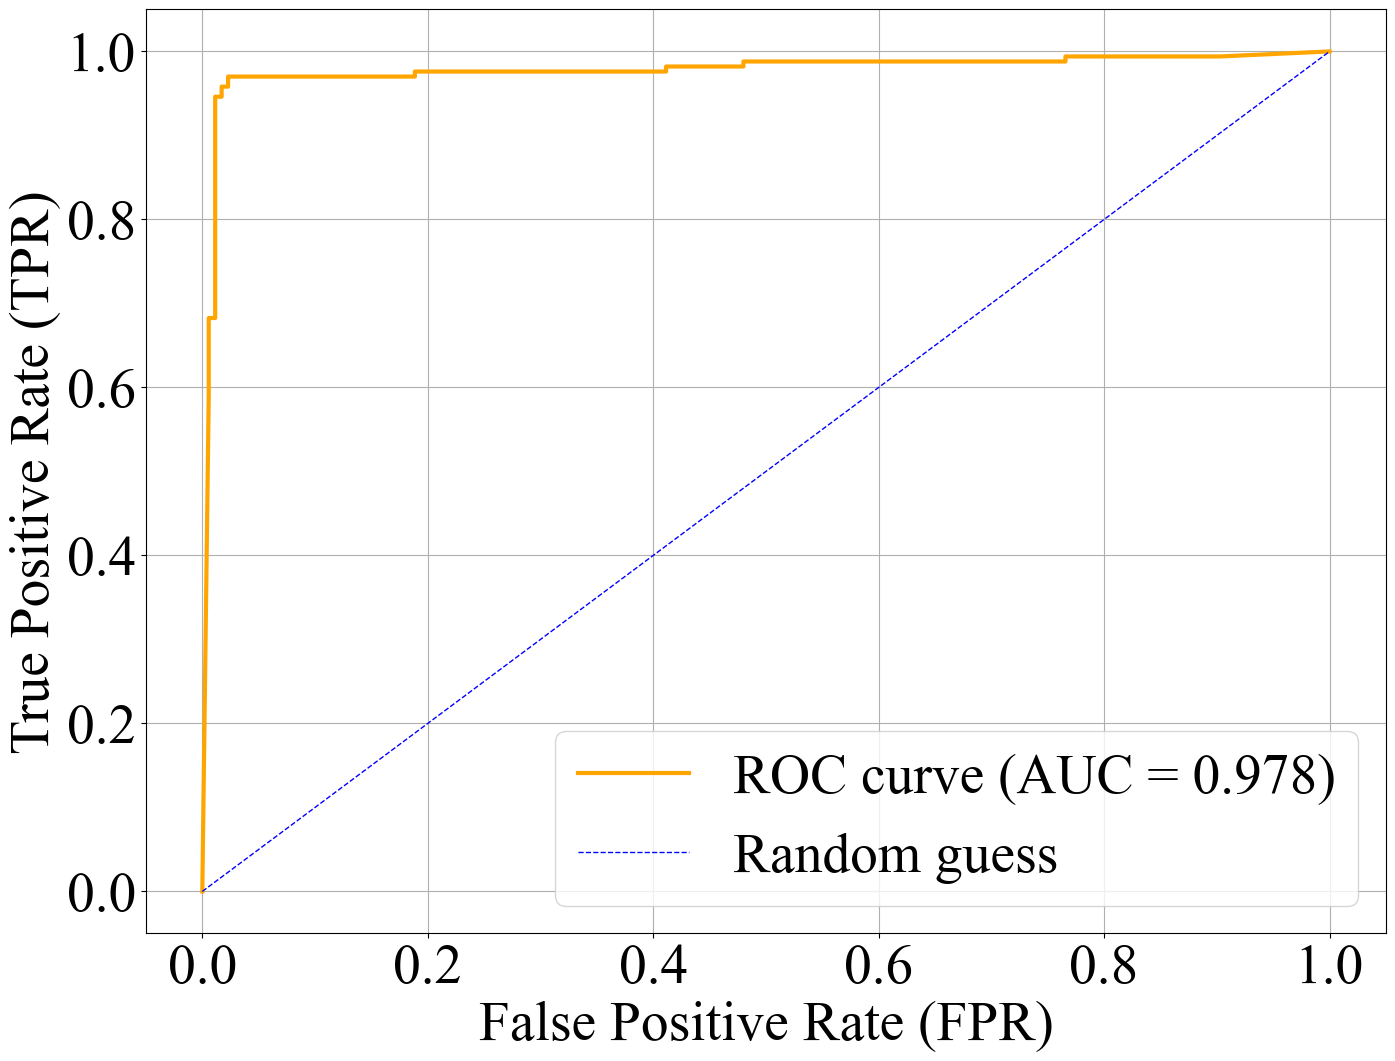

In [10]:
show_roc_curve(all_labels, cnn_probabilities, "CNN_roc.png")

## DETR ROC

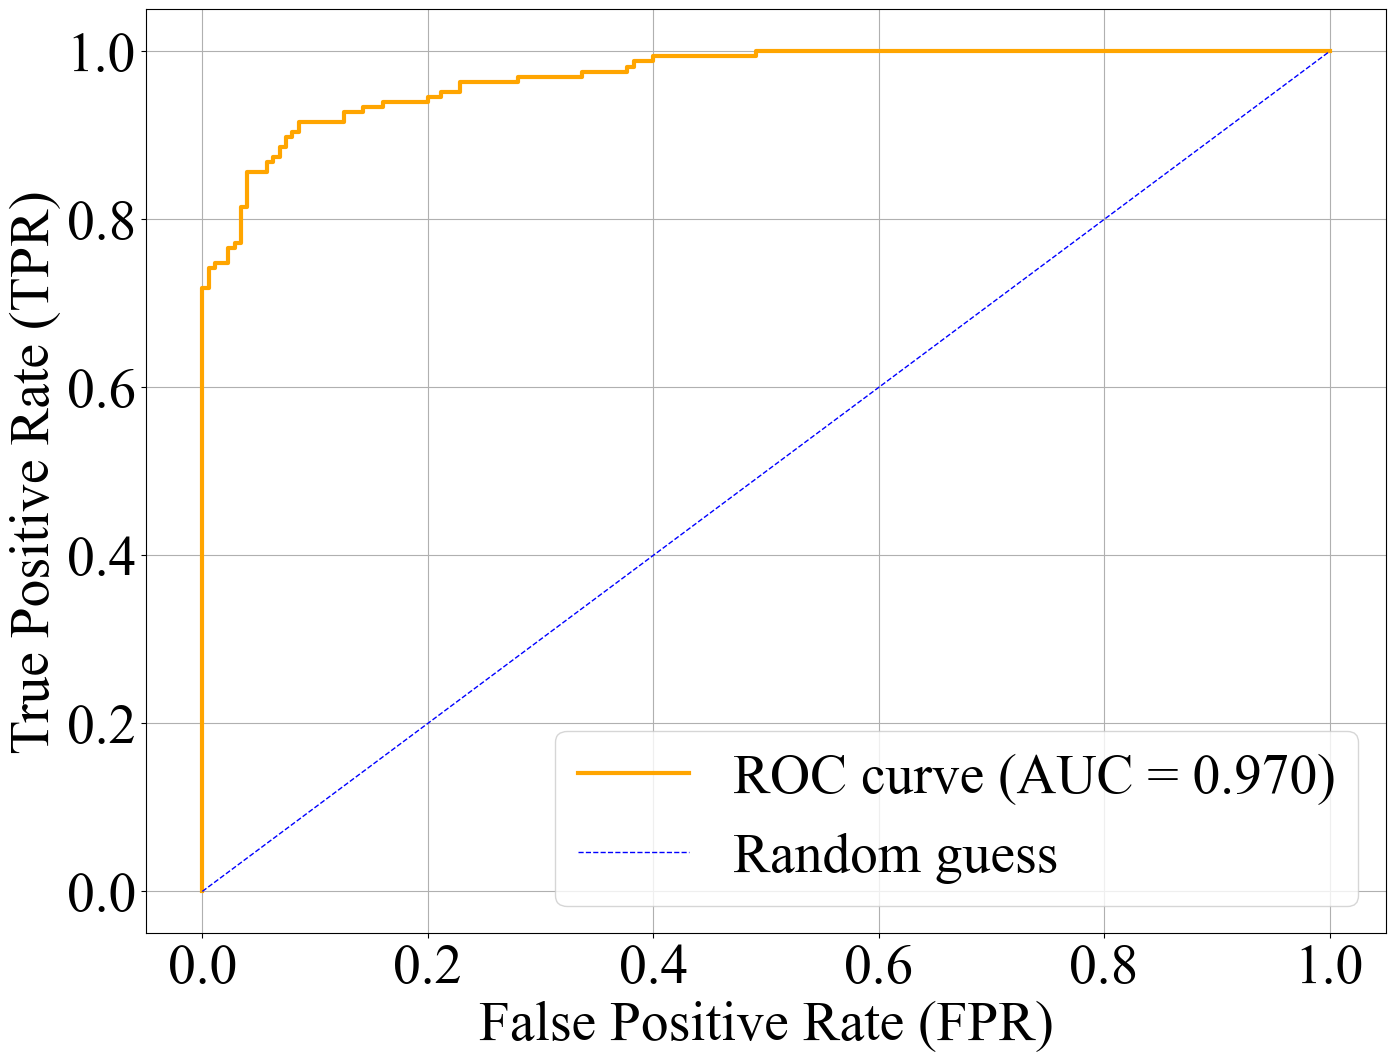

In [11]:
show_roc_curve(all_labels, detr_probabilities, "DETR_roc.png")

## Methane Mapper ROC

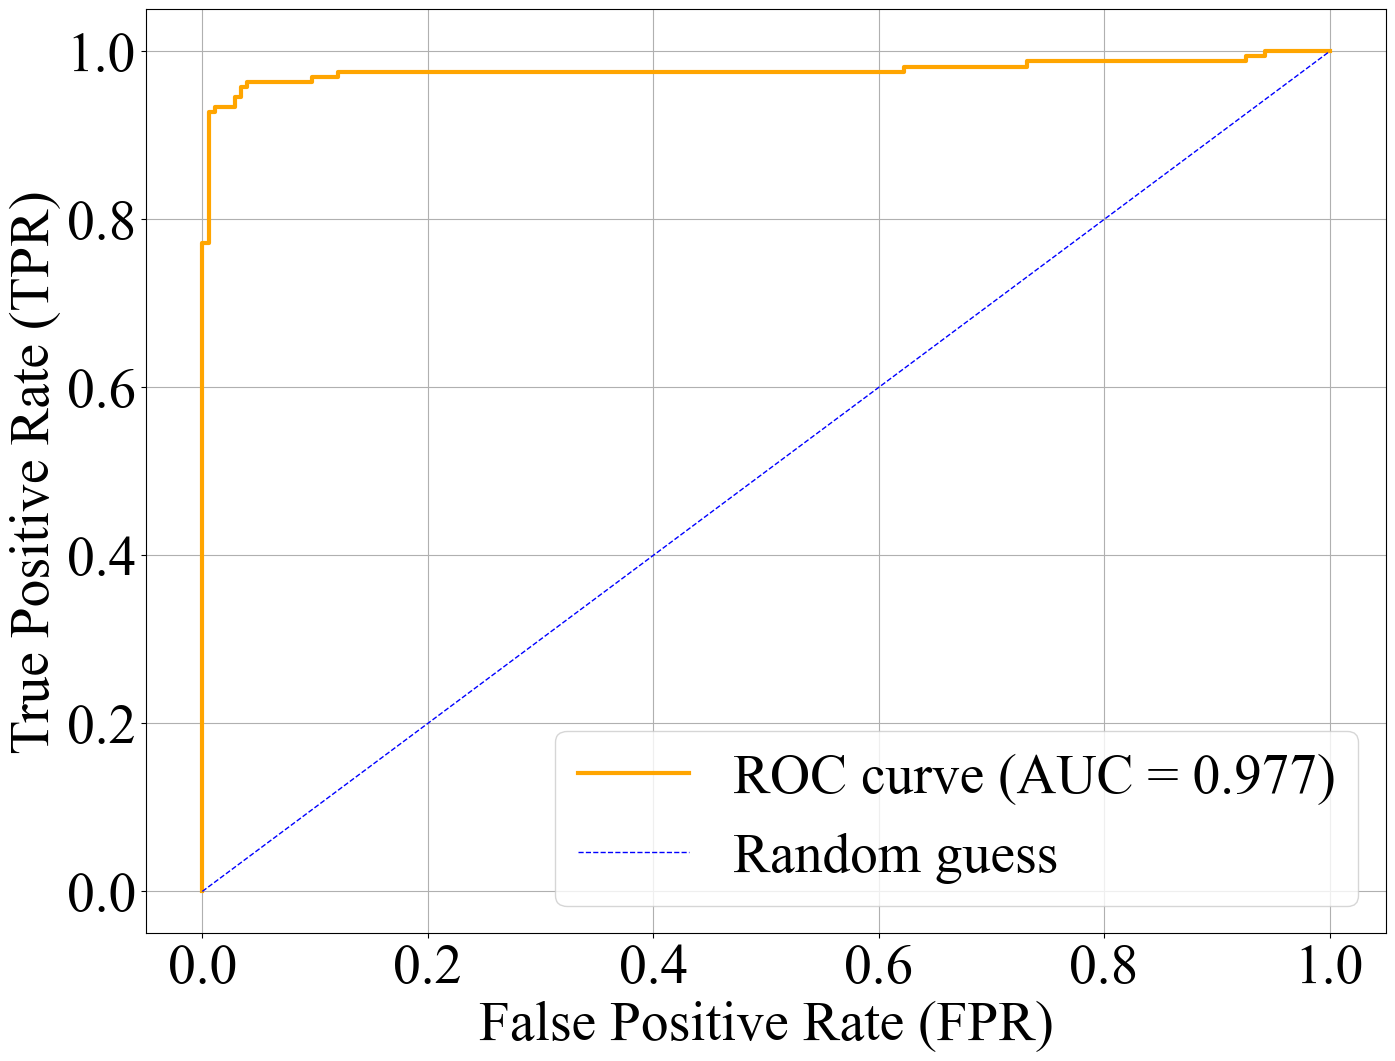

In [12]:
show_roc_curve(all_labels, mm_probabilities, "MM_roc.png")

## ViT ROC

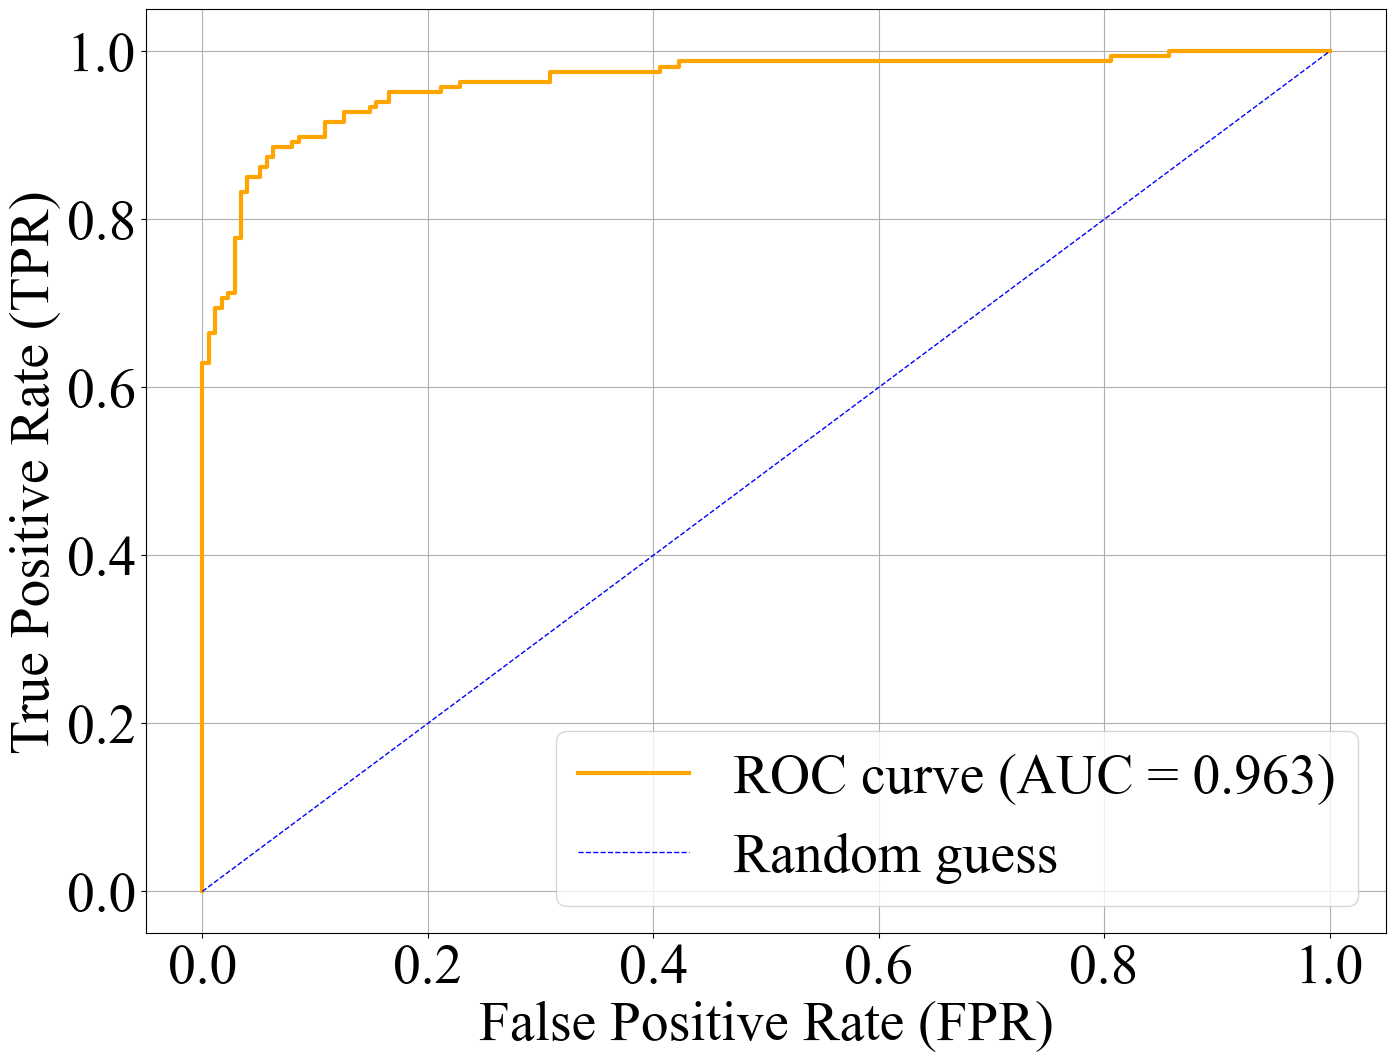

In [13]:
show_roc_curve(all_labels, vit_probabilities, "ViT_roc.png")

## Classifier Committee ROC

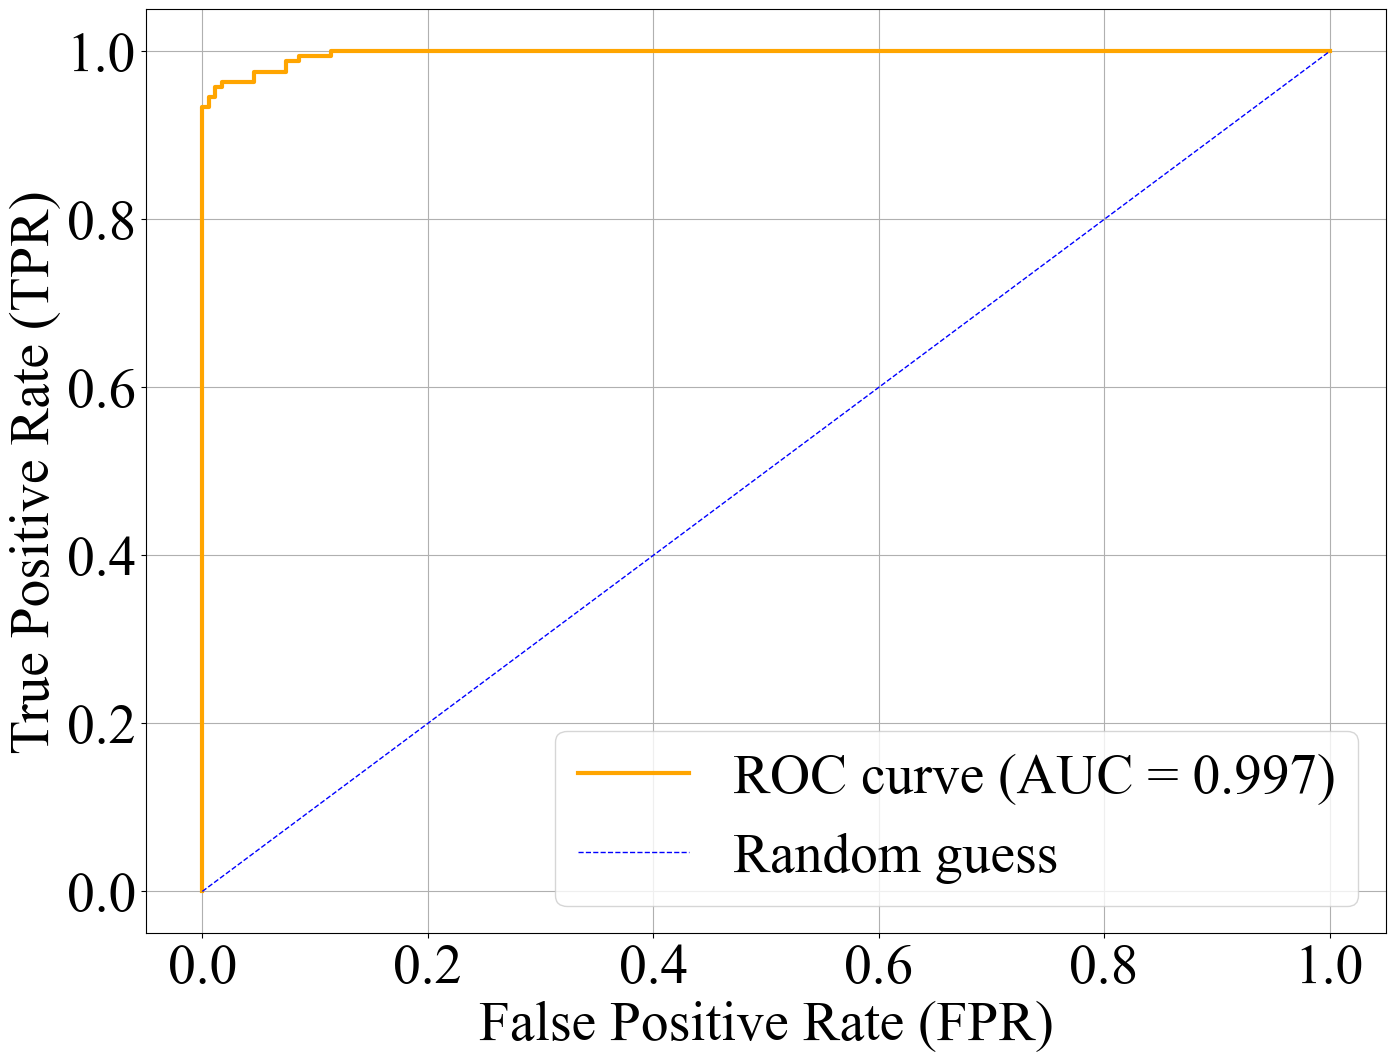

In [14]:
all_probabilities = np.array(cnn_probabilities) + np.array(detr_probabilities) + np.array(mm_probabilities)+ np.array(vit_probabilities)
all_probabilities = (all_probabilities/4).tolist()
show_roc_curve(all_labels, all_probabilities, "classifier_committee_roc.png")

## Merged ROC

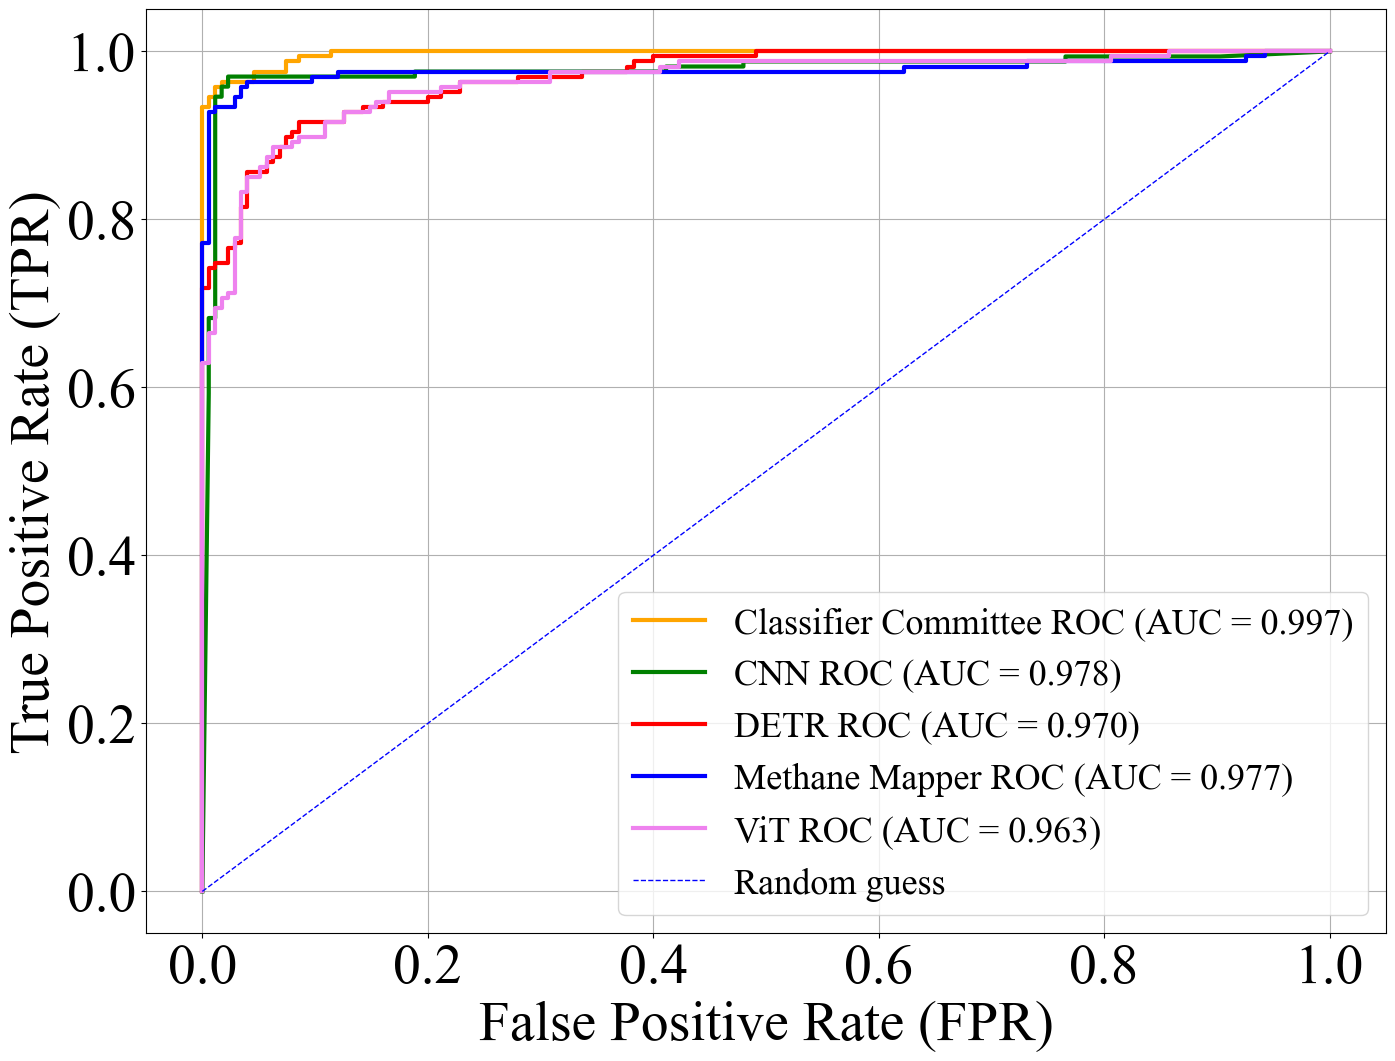

In [15]:
def add_roc_curve(labels, probabilities, color, model_name):
    fpr, tpr, thresholds = roc_curve(labels, probabilities)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, lw=3, label=f"{model_name} ROC (AUC = {roc_auc:.3f})")

plt.rcParams["font.size"] = 40
plt.rcParams["font.family"] = 'Times New Roman'
plt.figure(figsize=(16, 12))

add_roc_curve(all_labels, all_probabilities,  "orange",   "Classifier Committee")
add_roc_curve(all_labels, cnn_probabilities,  "green", "CNN")
add_roc_curve(all_labels, detr_probabilities, "red",  "DETR")
add_roc_curve(all_labels, mm_probabilities,   "blue",   "Methane Mapper")
add_roc_curve(all_labels, vit_probabilities,  "violet",  "ViT")

plt.plot([0, 1], [0, 1], color='blue', lw=1, linestyle='--', label="Random guess")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend(loc="lower right", fontsize=26)
plt.grid(True)
plt.savefig("merged_roc.png")
plt.show()